In [1]:
import os
import json
import torch
from transformers import BertTokenizer
import matplotlib.pyplot as plt
import pickle
from time import time
from datetime import timedelta

/projects/aieng/diffusion_bootcamp/env/diffusion-models-bootcamp-yasaman-in14eNW_-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# get file names
rootdir = "/datasets/PMC-15M/"
filenames = [fname for fname in os.listdir(rootdir) if fname.endswith(".jsonl") and not fname.endswith("_refs.jsonl")]
filenames = sorted(filenames, key=lambda x: int(x.replace(".jsonl", "")))
print("\n".join(filenames))

# create results directory
if not os.path.exists(os.path.join(rootdir, "text_lengths")):
    os.mkdir(os.path.join(rootdir, "text_lengths"))

0.jsonl
1.jsonl
2.jsonl
3.jsonl
4.jsonl
5.jsonl
6.jsonl
7.jsonl
8.jsonl
9.jsonl
10.jsonl
11.jsonl


In [ ]:
# load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

stime = time()

for fname in filenames:
    text_lengths = []
    print(f"[{timedelta(seconds=int(time() - stime))}] Loading file {fname}...")
    # load data
    with open(os.path.join(rootdir, fname)) as f:
        data = [json.loads(line)["caption"] for line in f]

    print(f"[{timedelta(seconds=int(time() - stime))}] Extracting caption lengths in {fname}...")
    for caption in data:
        tokens = tokenizer(caption, return_tensors='pt')
        text_lengths.append(tokens["input_ids"].reshape(-1).shape[0])
    
    print(f"[{timedelta(seconds=int(time() - stime))}] Saving caption lengths of {fname}...")
    save_path = os.path.join(rootdir, "text_lengths", fname.replace(".jsonl", ".pkl"))
    with open(save_path, "wb") as f:
        pickle.dump(text_lengths, f)
    print(f"[{timedelta(seconds=int(time() - stime))}] Saved caption lengths in {save_path}...")
print(f"[{timedelta(seconds=int(time() - stime))}] Successfully processed all files in {rootdir}")

In [3]:
os.listdir(os.path.join(rootdir, "text_lengths"))

['8.pkl',
 '5.pkl',
 '3.pkl',
 '1.pkl',
 '6.pkl',
 '7.pkl',
 '4.pkl',
 '2.pkl',
 '0.pkl']

In [3]:
import numpy as np

# load saved pickle files
text_lengths = []
for fname in os.listdir(os.path.join(rootdir, "text_lengths")):
    filename = os.path.join(rootdir, "text_lengths", fname)
    with open(filename, "rb") as f:
        text_lengths.extend(pickle.load(f))

text_lengths = np.array(text_lengths)
print(text_lengths.shape)

(11163147,)


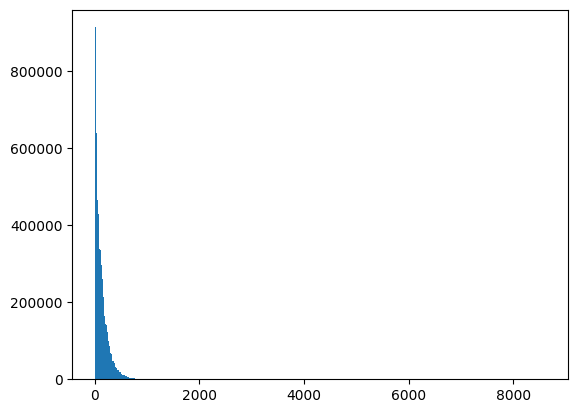

In [9]:
# plot histogram

values, bins, patches = plt.hist(text_lengths, bins=1000)

In [10]:
bins

array([2.000000e+00, 1.062300e+01, 1.924600e+01, ..., 8.607754e+03,
       8.616377e+03, 8.625000e+03])

In [11]:
# compute peak
print(f"peak of histogram: {sorted(list(zip(bins, values)), key=lambda x: x[1], reverse=True)[0]}")

peak of histogram: (10.623, 913232.0)


In [13]:
# compute quantile
np.quantile(text_lengths, q=0.99)

625.0

{'whiskers': [<matplotlib.lines.Line2D at 0x7f11f11862b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f11f11867f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f11f11f5fd0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f11f1186d30>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f11f1186fd0>],
 'means': []}

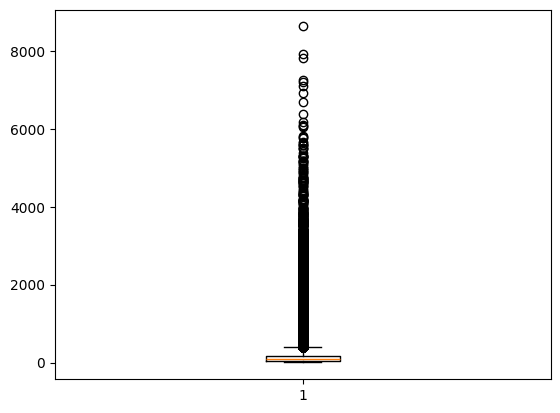

In [8]:
plt.boxplot(text_lengths)

In [19]:
np.sum(text_lengths < 256) / len(text_lengths)

0.8604472376830655

In [12]:
# compute q-values for 256 and 512 tokens
from scipy import special

f = np.linspace(0,1,101)
f

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [ ]:
0.5 - 0.5  * special.erf(f / np.sqrt(2)) # Q(f) = 0.5 - 0.5 erf(f/sqrt(2))